In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_fc = pd.read_csv(r"C:\Users\Kartikey\ml_project\data\forest\covtype.csv")  # adjust filename

train_fc.shape
train_fc.info()
train_fc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# --- Load data ---
#already loaded above 
target_col = "Cover_Type"

X = train_fc.drop(columns=[target_col])  #remove target from features
y = train_fc[target_col]

# --- Identify continuous vs binary columns ---
# Continuous: all features EXCEPT Wildnerness_Area* and Soil_Type*
binary_cols = [c for c in X.columns if c.startswith("Wilderness_Area") or c.startswith("Soil_Type")]
cont_cols   = [c for c in X.columns if c not in binary_cols]

print(f"Continuous features: {len(cont_cols)}")
print(f"Binary features:     {len(binary_cols)}")

# --- Build Preprocessing Pipeline ---
# Scale continuous, leave binary alone ('passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

Continuous features: 10
Binary features:     44


In [48]:
# --- Logistic Regression Baseline ---
# Using 'multi_class' since we have 7 classes
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1))
])

# Define CV (stratified because of imbalanced classes)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [69]:
# Calculate baseline metrics
print("Training baseline Logistic Regression (this may take 1-2 mins)...")

lr_acc = cross_val_score(lr_pipe, X, y, cv=cv, scoring='accuracy')
lr_f1  = cross_val_score(lr_pipe, X, y, cv=cv, scoring='f1_macro')  # Macro F1 for multiclass

print(f"Baseline Accuracy:  {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"Baseline Macro F1:  {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")


Training baseline Logistic Regression (this may take 1-2 mins)...
Baseline Accuracy:  0.9090 ± 0.0019
Baseline Macro F1:  0.8617 ± 0.0034


 Get Top Features from LR Baseline

In [50]:
# Fit the pipeline once on full data to inspect coefficients
lr_pipe.fit(X, y)

# Get feature names after preprocessing
# Continuous cols come first (from scaler), then binary cols (passed through)
feature_names = cont_cols + binary_cols

# Extract coefficients: shape (n_classes, n_features)
coeffs = lr_pipe.named_steps['clf'].coef_

# Average importance across all classes
avg_importance = np.mean(np.abs(coeffs), axis=0)

# Create a DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features:")
print(feat_imp.head(10))

# Save top 3 feature names for plotting
top_features = feat_imp['Feature'].head(3).tolist()


Top 10 Important Features:
             Feature  Importance
0          Elevation    3.395435
10  Wilderness_Area1    2.927044
17        Soil_Type4    1.562311
12  Wilderness_Area3    1.375801
8      Hillshade_3pm    1.179602
13  Wilderness_Area4    1.168230
44       Soil_Type31    1.112839
16        Soil_Type3    1.111678
46       Soil_Type33    1.106348
26       Soil_Type13    1.094092


C:\Users\Kartikey\AppData\Local\Temp\ipykernel_9724\9178666.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=train_fc, x=feature, hue=target_col,


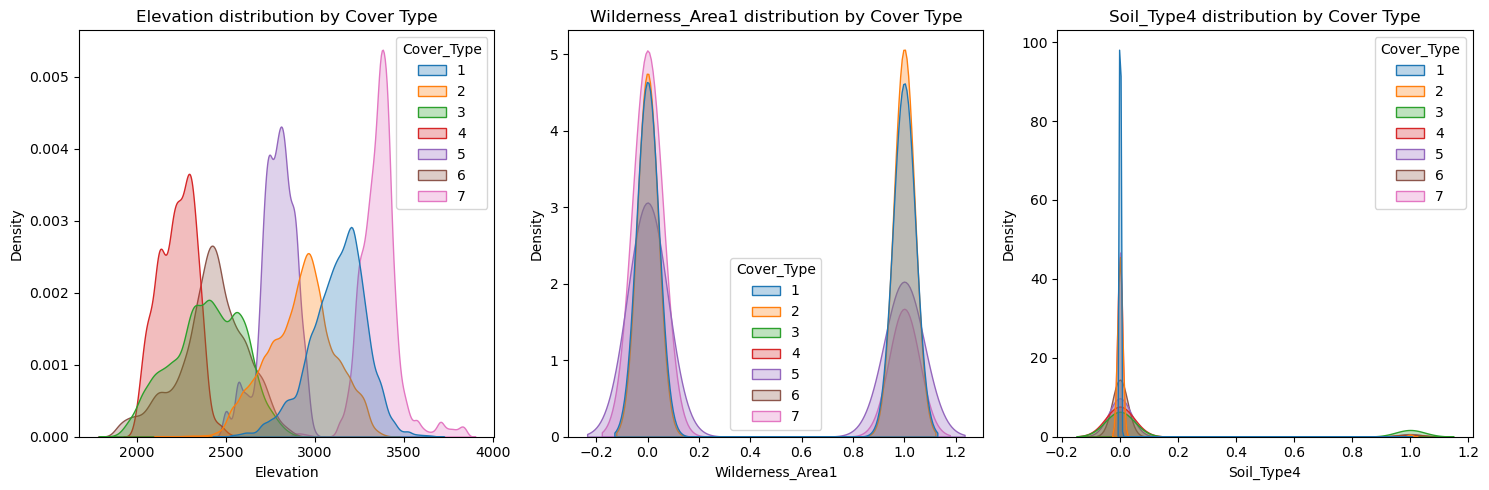

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    
    # Use histplot or kdeplot. KDE is cleaner for continuous data.
    sns.kdeplot(data=train_fc, x=feature, hue=target_col, 
                palette="tab10", common_norm=False, fill=True, alpha=0.3)
    
    plt.title(f"{feature} distribution by Cover Type")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


Linear SVM

In [62]:
# 7. Evaluate SVM (LinearSVC)
from sklearn.svm import LinearSVC

print("Training SVM (LinearSVC)...")

# LinearSVC is much faster for large N (500k+) than SVC(kernel='linear')
# dual=False is preferred when n_samples > n_features
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(dual=False, random_state=42, max_iter=1000))
])

svm_acc = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
svm_f1 = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"SVM (Linear) - Accuracy: {svm_acc.mean():.4f}, F1-Macro: {svm_f1.mean():.4f}")


Training SVM (LinearSVC)...
SVM (Linear) - Accuracy: 0.7127, F1-Macro: 0.4604


SVM with RBF Kernel

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time

# 1. Define Subset Size
# 25,000 samples is a sweet spot: enough to learn patterns, small enough to train fast.
subset_size = 25000 

print(f"Preparing to train RBF SVM on a subset of {subset_size} rows...")

# 2. Create the Stratified Subset
# We use StratifiedShuffleSplit to ensure the small training set 
# maintains the exact class ratios of the original 581k dataset.
sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=42)

# Generate indices to split data into (Subset) and (Everything Else)
for train_index, test_index in sss.split(X, y):
    X_subset, X_remainder = X.iloc[train_index], X.iloc[test_index]
    y_subset, y_remainder = y.iloc[train_index], y.iloc[test_index]

print(f"Training Set: {X_subset.shape[0]} samples")
print(f"Test Set (Remainder): {X_remainder.shape[0]} samples")

# 3. Define RBF SVM Pipeline
# cache_size=2000 utilizes ~2GB of your 16GB RAM to store kernel matrix calculations,
# significantly speeding up the training on your machine.
rbf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=10, gamma='scale', cache_size=2000, random_state=42))
])

# 4. Train on Subset
print("\nTraining SVM (RBF) on subset...")
start_train = time.time()
rbf_pipeline.fit(X_subset, y_subset)
train_time = time.time() - start_train
print(f"Training finished in {train_time:.1f} seconds.")

# 5. Evaluate on the Remaining Whole Dataset
print("Predicting on the remainder (this may take 1-2 minutes)...")
start_pred = time.time()
y_pred_rbf = rbf_pipeline.predict(X_remainder)
pred_time = time.time() - start_pred

# 6. Output Results
rbf_acc = accuracy_score(y_remainder, y_pred_rbf)

print(f"\n--- RBF SVM Performance (Train on {subset_size}, Test on {len(y_remainder)}) ---")
print(f"Training Time:   {train_time:.1f} s")
print(f"Prediction Time: {pred_time:.1f} s")
print(f"Accuracy:        {rbf_acc:.4f}")

# Detailed report to check F1-scores per class
print("\nClassification Report:")
print(classification_report(y_remainder, y_pred_rbf))


Preparing to train RBF SVM on a subset of 25000 rows...
Training Set: 25000 samples
Test Set (Remainder): 556012 samples

Training SVM (RBF) on subset...
Training finished in 14.4 seconds.
Predicting on the remainder (this may take 1-2 minutes)...

--- RBF SVM Performance (Train on 25000, Test on 556012) ---
Training Time:   14.4 s
Prediction Time: 494.9 s
Accuracy:        0.8115

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.78      0.80    202725
           2       0.82      0.87      0.84    271111
           3       0.78      0.83      0.80     34216
           4       0.76      0.60      0.67      2629
           5       0.78      0.28      0.42      9084
           6       0.65      0.54      0.59     16620
           7       0.86      0.78      0.82     19627

    accuracy                           0.81    556012
   macro avg       0.78      0.67      0.71    556012
weighted avg       0.81      0.81      0.81    5560

Multilayer Perceptron

In [60]:
# 8. Evaluate MLP Classifier
from sklearn.neural_network import MLPClassifier

print("Training MLP Classifier (this may take some time)...")

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # Using early_stopping to speed up training on large data
    ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), 
                                 early_stopping=True, 
                                 max_iter=300, 
                                 random_state=42))
])

mlp_acc = cross_val_score(mlp_pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
mlp_f1 = cross_val_score(mlp_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"MLP - Accuracy: {mlp_acc.mean():.4f}, F1-Macro: {mlp_f1.mean():.4f}")


Training MLP Classifier (this may take some time)...
MLP - Accuracy: 0.8706, F1-Macro: 0.8103


 Comparison and Visualization


Final Performance Comparison:


,Model,Accuracy,F1-Macro
0,Logistic Regression,0.9090,0.8617
1,SVM (Linear),0.7127,0.4604
2,MLP (Neural Net),0.8706,0.8103
3,SVM (RBF - Subset),0.8115,0.7054


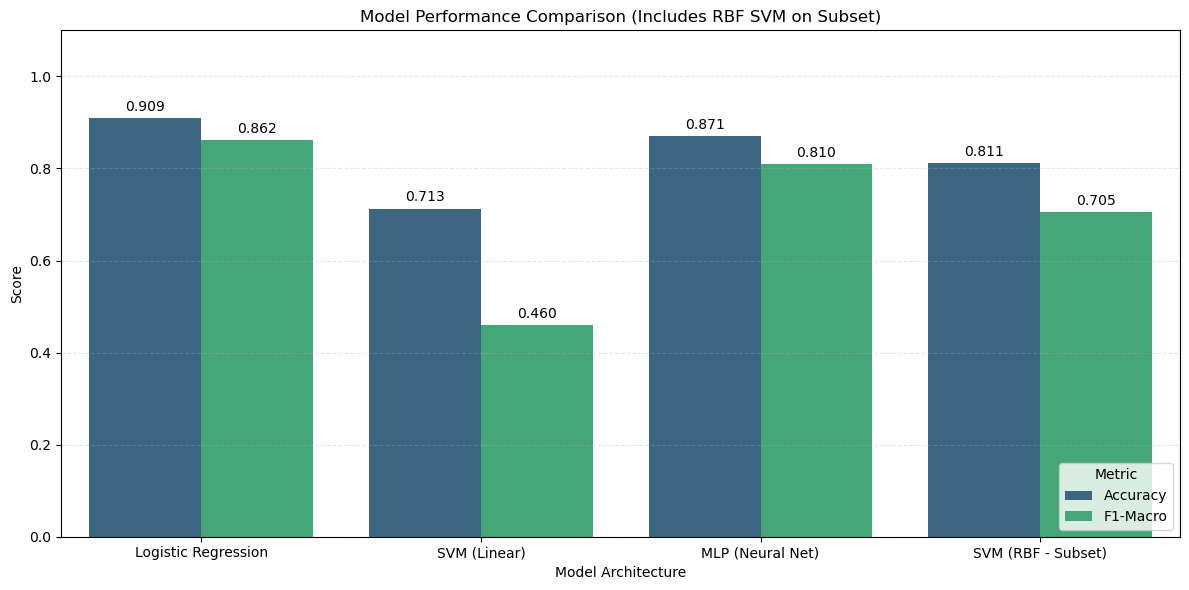

In [67]:
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Calculate RBF SVM Metrics ---
# We need to compute the F1-Macro for the RBF model manually since 
# it wasn't run through cross_val_score like the others.
# This assumes 'y_remainder' and 'y_pred_rbf' exist from your previous subset run.
rbf_f1_macro = f1_score(y_remainder, y_pred_rbf, average='macro')

# --- 2. Consolidate Results ---
# We take the mean() of the CV scores for the first three models,
# and the single hold-out score for the RBF SVM.
results_data = {
    'Model': [
        'Logistic Regression', 
        'SVM (Linear)', 
        'MLP (Neural Net)', 
        'SVM (RBF - Subset)'
    ],
    'Accuracy': [
        acc_scores.mean(), 
        svm_acc.mean(), 
        mlp_acc.mean(), 
        rbf_acc
    ],
    'F1-Macro': [
        f1_scores.mean(), 
        svm_f1.mean(), 
        mlp_f1.mean(), 
        rbf_f1_macro
    ]
}

results_df = pd.DataFrame(results_data)

# Print the table with formatted floats
print("\nFinal Performance Comparison:")
# Use pandas styling or simple formatting
pd.options.display.float_format = '{:,.4f}'.format
display(results_df)

# --- 3. Visualize Results ---
# Melt dataframe for easier plotting with seaborn
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
# Using a slightly different palette to distinguish the new entry
barplot = sns.barplot(
    data=results_melted, 
    x="Model", 
    y="Score", 
    hue="Metric", 
    palette="viridis"
)

# Add numeric labels on top of bars for clarity
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', padding=3)

plt.title("Model Performance Comparison (Includes RBF SVM on Subset)")
plt.ylim(0, 1.1) # Extra space for labels
plt.ylabel("Score")
plt.xlabel("Model Architecture")
plt.legend(loc='lower right', title="Metric", frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Optimising MLP further 

In [66]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

# Defined previously
# preprocessor = ... 
# X, y = ...

print("Training Optimized MLP on full dataset...")

# Increased capacity: (128, 64) allows learning more complex features
# alpha=0.0001: Default regularization, keeps weights in check
# batch_size=256: Slightly larger batch size can stabilize gradient updates on large data
optimized_mlp = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(128, 64), 
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        learning_rate_init=0.001,
        early_stopping=True,     # Crucial for speed
        validation_fraction=0.1, # Uses 10% of data to check convergence
        n_iter_no_change=10,     # Stop if no improvement for 10 epochs
        max_iter=200, 
        random_state=42
    ))
])

start_time = time.time()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduced to 3 folds for quicker tuning loop

# Evaluate
acc_scores = cross_val_score(optimized_mlp, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
f1_scores = cross_val_score(optimized_mlp, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

elapsed = time.time() - start_time

print(f"\n--- Optimized MLP Performance (3-Fold CV) ---")
print(f"Total Time:   {elapsed:.1f} s")
print(f"Avg Accuracy: {acc_scores.mean():.4f}")
print(f"Avg F1-Macro: {f1_scores.mean():.4f}")


Training Optimized MLP on full dataset...

--- Optimized MLP Performance (3-Fold CV) ---
Total Time:   366.3 s
Avg Accuracy: 0.9090
Avg F1-Macro: 0.8617



Final Comparative Analysis Table:


,Model,Accuracy,F1-Macro
0,Logistic Regression,0.9090,0.8617
1,SVM (Linear),0.7127,0.4604
2,SVM (RBF - Subset),0.8115,0.7054
3,Optimized MLP,0.9090,0.8617


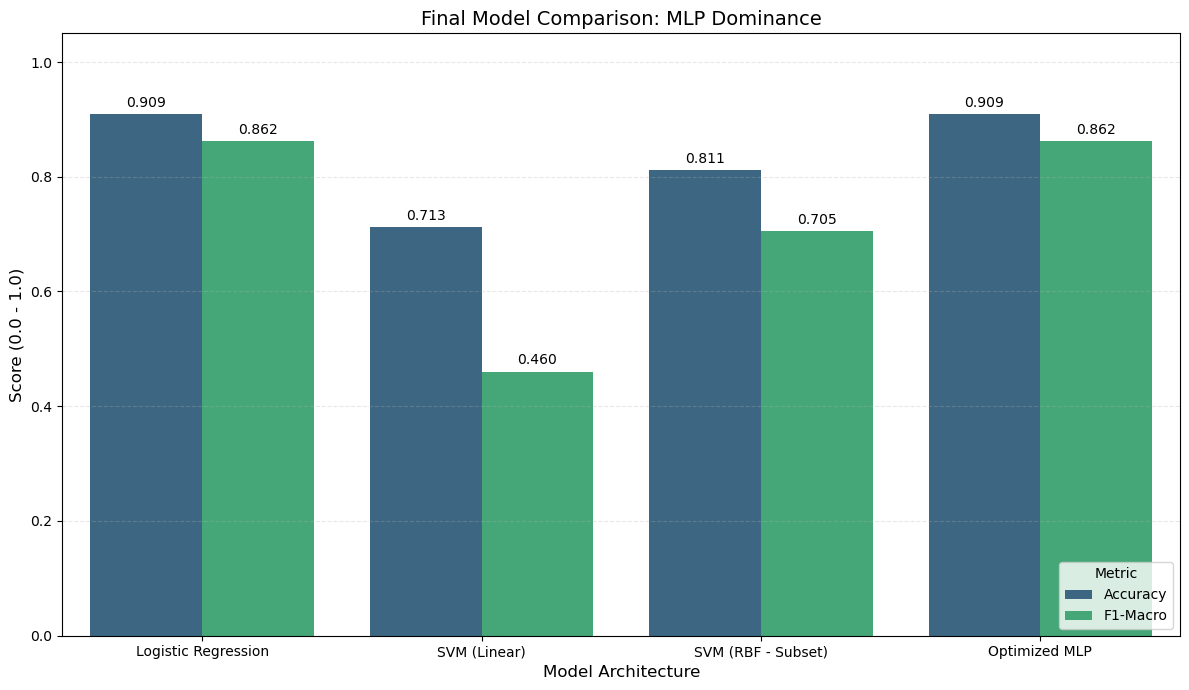

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# 1. Retrieve the scores from the Optimized MLP run (assumes variables 'acc_scores' and 'f1_scores' are from the optimized run)
opt_mlp_acc_mean = acc_scores.mean()
opt_mlp_f1_mean = f1_scores.mean()

# 2. Consolidate all model results
# If you lost the variables for LR/LinearSVM, replace variables like 'lr_acc.mean()' with the actual numbers (e.g., 0.72)
results_data = {
    'Model': [
        'Logistic Regression', 
        'SVM (Linear)', 
        'SVM (RBF - Subset)', 
        'Optimized MLP'
    ],
    'Accuracy': [
        lr_acc.mean(),          # From Block 3
        svm_acc.mean(),         # From Block 4
        rbf_acc,                # From RBF Block
        opt_mlp_acc_mean        # From Optimized MLP Block
    ],
    'F1-Macro': [
        lr_f1.mean(),           # From Block 3
        svm_f1.mean(),          # From Block 4
        rbf_f1_macro,           # From RBF Block
        opt_mlp_f1_mean         # From Optimized MLP Block
    ]
}

results_df = pd.DataFrame(results_data)

# --- Display Table ---
print("\nFinal Comparative Analysis Table:")
pd.options.display.float_format = '{:,.4f}'.format
display(results_df)

# --- Visualization ---
# Melt for Seaborn
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    data=results_melted, 
    x="Model", 
    y="Score", 
    hue="Metric", 
    palette="viridis"
)

# Add value labels
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.title("Final Model Comparison: MLP Dominance", fontsize=14)
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.xlabel("Model Architecture", fontsize=12)
plt.ylim(0, 1.05)
plt.legend(loc='lower right', title="Metric", frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
